In [1]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [3]:
#Visualising Data
classes = []
img_classes = []
n_image = []

# Using folder names to identify classes
for folder in os.listdir('dataset'):
    classes.append(folder)
    images = os.listdir('dataset/'+folder)
    n_image.append(len(images)) 
    for i in images:
        img_classes.append(folder)
    
df = pd.DataFrame({
    'classes': img_classes,
    'classes': classes,
    'number': n_image
})
df

,classes,number
0,0,3688
1,1,9571


In [4]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=128, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=128),
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=128),
        transforms.ToTensor(),
    ]),
}

In [5]:
batch_size = 64

all_data = datasets.ImageFolder(root='dataset')

train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['test']

print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

10607 1326 1326


In [6]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64])


In [7]:
model = models.vgg16(pretrained=True)

In [8]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [9]:
n_classes = 2
n_inputs = model.classifier[6].in_features
# n_inputs will be 4096 for this case
# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1))

In [10]:
criterion = nn.NLLLoss()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_ for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, '0'), (1, '1')]

In [12]:
def train(model,criterion,optimizer,train_loader,val_loader,save_location,early_stop=3,n_epochs=20,print_every=2):
#Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

#Loop starts here
    for epoch in range(n_epochs):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0
    
        model.train()
        ii = 0
    
        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)
      
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
      
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
      
            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1) # first output gives the max value in the row(not what we want), second output gives index of the highest val
            correct_tensor = pred.eq(label.data.view_as(pred)) # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) #tensor must be float to calc average
            train_acc += accuracy.item() * data.size(0)
            if ii%15 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()
      
            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()
        
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)
        
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)
    
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(val_loader.dataset)
      
        train_acc = train_acc / len(train_loader.dataset)
        valid_acc = valid_acc / len(val_loader.dataset)
      
        history.append([train_loss, valid_loss, train_acc, valid_acc])
      
        if (epoch + 1) % print_every == 0:
            print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
            print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_location)
            stop_count = 0
            valid_loss_min = valid_loss
            valid_best_acc = valid_acc
            best_epoch = epoch
        
        else:
            stop_count += 1
        
        # Below is the case where we handle the early stop case
        if stop_count >= early_stop:
            print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
            model.load_state_dict(torch.load(save_location))
            model.optimizer = optimizer
            history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
            return model, history
        
    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
  
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [14]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./Models/RCNN.pt',
    early_stop=5,
    n_epochs=30,
    print_every=2)

Epoch: 0	9.64% complete.
Epoch: 0	18.67% complete.
Epoch: 0	27.71% complete.
Epoch: 0	36.75% complete.
Epoch: 0	45.78% complete.
Epoch: 0	54.82% complete.
Epoch: 0	63.86% complete.
Epoch: 0	72.89% complete.
Epoch: 0	81.93% complete.
Epoch: 0	90.96% complete.
Epoch: 0	100.00% complete.
Epoch: 1	9.64% complete.
Epoch: 1	18.67% complete.
Epoch: 1	27.71% complete.
Epoch: 1	36.75% complete.
Epoch: 1	45.78% complete.
Epoch: 1	54.82% complete.
Epoch: 1	63.86% complete.
Epoch: 1	72.89% complete.
Epoch: 1	81.93% complete.
Epoch: 1	90.96% complete.
Epoch: 1	100.00% complete.

Epoch: 1 	Training Loss: 0.0602 	Validation Loss: 0.0547
		Training Accuracy: 98.00%	 Validation Accuracy: 97.96%
Epoch: 2	9.64% complete.
Epoch: 2	18.67% complete.
Epoch: 2	27.71% complete.
Epoch: 2	36.75% complete.
Epoch: 2	45.78% complete.
Epoch: 2	54.82% complete.
Epoch: 2	63.86% complete.
Epoch: 2	72.89% complete.
Epoch: 2	81.93% complete.
Epoch: 2	90.96% complete.
Epoch: 2	100.00% complete.
Epoch: 3	9.64% complete.
Ep

Epoch: 23	81.93% complete.
Epoch: 23	90.96% complete.
Epoch: 23	100.00% complete.

Epoch: 23 	Training Loss: 0.0312 	Validation Loss: 0.0479
		Training Accuracy: 98.97%	 Validation Accuracy: 98.49%

Early Stopping Total epochs: 23. Best epoch: 18 with loss: 0.03 and acc: 98.49%


In [15]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,0.066714,0.051349,0.976525,0.981900
1,0.060184,0.054710,0.980013,0.979638
2,0.055294,0.047751,0.981616,0.981900
3,0.050522,0.038916,0.982747,0.982655
4,0.048472,0.046664,0.983501,0.984917
5,0.045600,0.039806,0.983124,0.987934
6,0.048142,0.036971,0.984350,0.984917
7,0.042628,0.036898,0.986424,0.988688
8,0.043672,0.034631,0.985010,0.984163
9,0.038267,0.033850,0.988404,0.985671


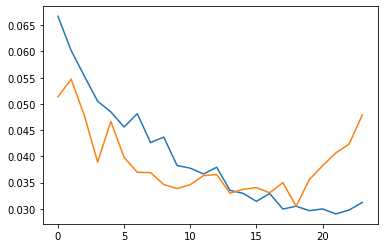

In [16]:
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])

In [17]:
def accuracy(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
      
            output = model(data)
      
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)
    
    test_acc = test_acc / len(test_loader.dataset)
    return test_acc

In [19]:
model.load_state_dict(torch.load('./Models/RCNN.pt'))
test_acc = accuracy(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 99.10% on the test dataset


In [20]:
def evaluate(model, test_loader, criterion):
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            
            output = model(data)
      
            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()])
                i+=1
  
    results = pd.DataFrame({
        'class': classes,
        'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

In [21]:
evaluate(model, test_loader, criterion)

,results
0,0.986979
1,0.992569


In [22]:
transform = transforms.Compose([
        transforms.ToPILImage(), #if isinstance np.ndarray
        transforms.Resize(size=128),
        transforms.ToTensor()
    ])

tensor([[-0.0007]], device='cuda:0', grad_fn=<TopkBackward>) tensor([[1]], device='cuda:0')


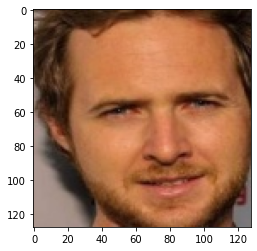

In [23]:
img = cv2.cvtColor(cv2.imread('dataset/1/2.jpg'), cv2.COLOR_BGR2RGB)
tensor = transform(img).unsqueeze(0).cuda().float()
output = model(tensor)
val, indice = output.topk(1) #prend la plus grand valeur
print(val, indice)
plt.imshow(img)

In [24]:
import time

def getboxes(image):
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    imout = image.copy()
    return imout, ss.process()

tensor([[-3.8265e-05]], device='cuda:0', grad_fn=<TopkBackward>)
4.355303049087524


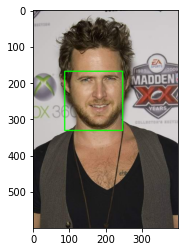

In [26]:
un = torch.tensor([[1]]).cuda()
seuil = torch.tensor([[-0.0007]]).cuda()
filename = "2.jpg"
file = os.path.join("Image",filename)
image = cv2.imread(file)
imout, boxes = getboxes(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
a = time.time()
for boxe in boxes:
    x,y,w,h = boxe
    timage = imout[y:y+h,x:x+w]
    tensor = transform(timage).unsqueeze(0).cuda().float()
    output = model(tensor)
    val, indice = output.topk(1)
    if torch.eq(indice, un) and val > seuil:
        print(val)
        cv2.rectangle(imout, (x, y), ((x+w), (y+h)), (0, 255, 0), 2, cv2.LINE_AA)
        break
b = time.time()
print(b-a)
plt.figure
plt.imshow(imout)